In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from single_photons.estimators.kalman import KalmanFilter
from single_photons.utils.constants import *
from single_photons.environment import Cavity_Particle

In [35]:
import numpy as np
import single_photons.utils.constants as ct


class Cavity_Particle:
    def __init__(self, omega_p, gamma, omega_c, kappa, g_cs, coupling, eta_detection=1, radius=147e-9, rho=2200):  
        self.__omega_p__ = omega_p
        self.__gamma__ = gamma
        self.__omega_c__ = omega_c
        self.__kappa__ = kappa
        self.__g_cs__ = g_cs
        self.A = np.array([[-self.__kappa__/2, self.__omega_c__, 0, 0],
                           [-self.__omega_c__, -self.__kappa__/2, self.__g_cs__, 0],
                           [0, 0, 0, self.__omega_p__],
                           [self.__g_cs__, 0, -self.__omega_p__, -self.__gamma__]])
        self.B = np.array([[0], [0], [0], [1]])
        self.C = np.array([[0, 0, 1, 0]])
        self.G = np.array([[0], [0], [0], [1]])
        self.backaction = np.sqrt(4*np.pi*coupling)
        self.eta_det = eta_detection
        self._m_ = rho*4*np.pi*np.power(radius, 3)/3
        self.zp_x = np.sqrt(ct.hbar/(omega_p*self._m_))
        self.zp_p = np.sqrt(omega_p*ct.hbar*self._m_)

    def __backaction_fluctuation__(self):
        return self.backaction*(np.sqrt(self.eta_det)*np.random.normal()+np.sqrt(1-self.eta_det)*np.random.normal())

    def step(self, states, alpha_in = 0, control=0.0, delta_t=50e-2):
        if states.size > 4:
            raise ValueError('States size for this specific system is equal to two \
                (position and velocity)')
        backaction_force = self.__backaction_fluctuation__()
        thermal_force = np.sqrt(2*self.__gamma__)*np.random.normal()
        x_in = np.sqrt(self.__kappa__)*(np.conjugate(alpha_in) + alpha_in)
        y_in = 1j*np.sqrt(self.__kappa__)*(np.conjugate(alpha_in) - alpha_in)
        optical_input = np.array([[x_in], [y_in], [0], [0]])
        print(optical_input)
        state_dot = np.matmul(self.A,states) + self.B*control
        states = states + state_dot*delta_t + self.G*np.sqrt(delta_t)*(thermal_force+backaction_force) + optical_input
        return states

In [36]:
omega = 2*np.pi*1e5
omega_c = 1e12
kappa = 1e6
g_cs = 1e4
T = 2*np.pi/omega
t = np.arange(0, 1*T, T/400)
N = t.shape[0]
delta_t = np.diff(t)[0]

In [44]:
gamma = 1e3
coupling = 0.01
eta_detec=0.9
env = Cavity_Particle(omega, gamma, omega_c, kappa, g_cs, coupling, eta_detection=eta_detec)

In [45]:
variance_process = 2*env.__gamma__ + np.power(env.backaction, 2)
std_detection = 4

In [46]:
Q = np.array([[0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, 0],
              [0, 0, 0, variance_process]])
R = np.array([[np.power(std_detection,2)]])

In [47]:
Ad = np.eye(4)+env.A*delta_t+0.5*np.matmul(env.A*delta_t, env.A*delta_t)

In [48]:
P0 = 100*np.matrix(np.eye(4))
estimation = np.matrix([[0],[0],[0],[0]])
states = np.array([[0.],[0.],[100],[0.]])
K = np.array([[0, 0, 1, 1e5]])
new_states = np.zeros((N,4)) 
kalman = KalmanFilter(estimation, P0, Ad, env.B*delta_t, env.C, Q, R)
measured_states = np.zeros((N))
estimated_states = np.zeros((N, 4))
estimated_states[0,:] = estimation.reshape((4))
estimation = estimation.reshape((4,1))
for i in tqdm(range(t.shape[0])):
    u = -np.matmul(K, estimation).sum()
    print(u)
    new_states[i,:] = states[:,0]
    measured_states[i] = states[0, 0] + std_detection*np.random.normal()
    kalman.propagate_dynamics(np.array([[u]]))
    kalman.compute_aposteriori(measured_states[i])
    estimated_states[i,:] = kalman.estimates_aposteriori[i][:,0].reshape((4))
    estimation = estimated_states[i,:].reshape((4,1))    
    states = env.step(states, control=u, delta_t=delta_t)

  0%|                                                                                                                                                                                                                                | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_18188/2073616470.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  new_states[i,:] = states[:,0]
/tmp/ipykernel_18188/2073616470.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  measured_states[i] = states[0, 0] + std_detection*np.random.normal()
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 2032.10it/s]

-0.0
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
-0.0
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
-0.19219584233564987
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
-535730.5633634587
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
-3.299535356171015e+22
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
3.93742819680928e+26
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
-9.284826000821839e+33
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
-1.0008016578069067e+42
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
2.275432827409672e+37
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
8.031019782415897e+44
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
-5.925312898533321e+51
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
2.4733004953851423e+56
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
1.6453488010783352e+63
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
1.3027551752536989e+70
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
1.4336900363623179e+66
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
-3.5977284617766524e+73
[[0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]
2.7704274818369324e+

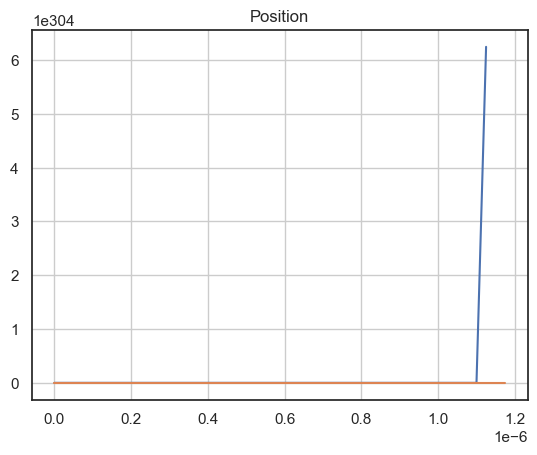

In [49]:
fig = plt.Figure()
plt.title('Position')
plt.plot(t, estimated_states[:,0])
plt.plot(t, new_states[:,0])
plt.grid()
plt.show()

In [26]:
z = estimated_states[:,0]*env.zp_x
p = estimated_states[:,1]*env.zp_p

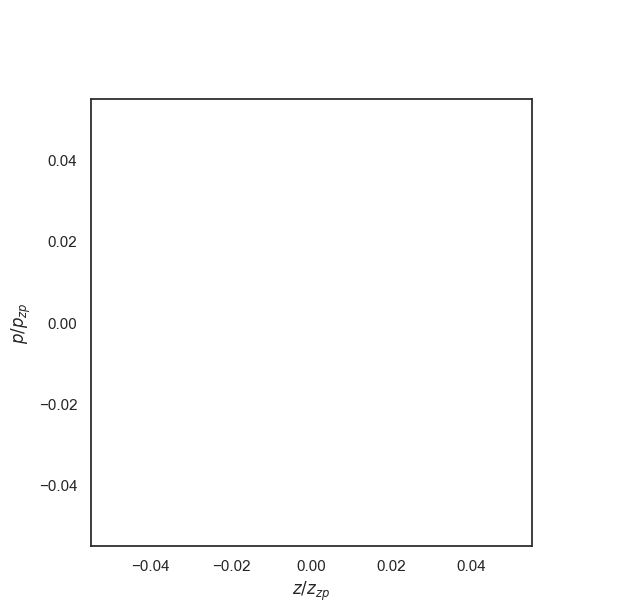

In [10]:
sns.set_theme(style="white")
df = pd.DataFrame()
df['z'] = estimated_states[100:,0]
df['p'] = estimated_states[100:,1]
g = sns.JointGrid(data=df, x="z", y="p", space=0)
g.plot_joint(sns.lineplot, sort = False)#clip=((2200, 6800), (10, 25)),
             #thresh=0, levels=100, cmap="rocket")
g.plot_marginals(sns.kdeplot, alpha=1, fill=True)
g.set_axis_labels(r'$z/z_{zp}$',r'$p/p_{zp}$')

In [ ]:
plt.plot(df['z'], df['p'])

In [ ]:
cov_mat = kalman.error_covariance_aposteriori[-1]
z_std = env.zp_x*np.sqrt(cov_mat[0,0])
p_std = env.zp_p*np.sqrt(cov_mat[1,1])
cov_mat

In [ ]:
estimated_states[-30:].var(axis=0)

In [ ]:
(env._m_*np.power(env.__omega__, 2)*np.power(z_std,2)+np.power(p_std,2)/env._m_)/(2*hbar*env.__omega__)

In [ ]:
z_std*p_std > hbar/2